In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import pickle
from dateutil import relativedelta
import seaborn as sns

# Needs to be refactored to use new nipoppy tabular organization

### Paths


In [3]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy manifest
release_dir = f"{DATASET_ROOT}/releases/"
current_release = "June_2024"

tabular_data_release_dir = f"{release_dir}/{current_release}/"

demo_config_json = "../workflow/tabular/demographics.json"
pheno_config_json = "../workflow/tabular/pheno.json"


### Standardized index names

In [4]:
baseline_event_name = "Baseline (Arm 1: C-OPN)"

## redcap event name variations
config_data = json.load(open(demo_config_json))
data_sources = config_data['data_sources']
redcap_data_sources = data_sources['redcap']

redcap_field_name_map = {}

for instrument in redcap_data_sources.keys():
    index_cols = redcap_data_sources[instrument]['index_cols']
    record_id = index_cols[0]
    event_name = index_cols[1]

    redcap_field_name_map[record_id] = "participant_id"
    redcap_field_name_map[event_name] = "redcap_event_name"
print(f"redcap_field_name_map: {redcap_field_name_map}")

# legacy participant_id variations in DOB and BD_RPQ
legacy_field_name_map = {}
legacy_field_name_map['Record ID'] = "participant_id"
legacy_field_name_map['Patient #'] = "participant_id"
legacy_field_name_map['Name of visit (V01, V02, V03)'] = "visit"
print(f"legacy_field_name_map: {legacy_field_name_map}")

redcap_field_name_map: {'Record ID:': 'participant_id', 'Event Name': 'redcap_event_name', 'record_id': 'participant_id', 'redcap_event_name': 'redcap_event_name'}
legacy_field_name_map: {'Record ID': 'participant_id', 'Patient #': 'participant_id', 'Name of visit (V01, V02, V03)': 'visit'}


### Update RedCAP reports through API 
(Not updating extended report since it has to come from Sarah)
- "global_records_query"
- "QPN MoCA-UPDRS-Neuropsy data_Sarah"

In [5]:
update_redcap_reports = False

redcap_report_list = ["global_records_query", "QPN MoCA-UPDRS-Neuropsy data_Sarah"]
if update_redcap_reports:
    redcap_config_json = f"{DATASET_ROOT}/proc/.redcap.json"
    redcap_config = json.load(open(redcap_config_json))
    url = redcap_config["url"]
    
    for redcap_report in redcap_report_list:
        print(f"Getting data for RedCap report: {redcap_report}")
        records_query = redcap_config["queries"][redcap_report]
        query_df = api_call(url, records_query, logger=None)
        report_csv = f"{release_dir}{current_release}/tabular/redcap/{redcap_report}.csv"
        query_df.to_csv(report_csv, index=False)
        print(f"Saved RedCap report to {report_csv}")



Getting data for RedCap report: global_records_query


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'redcap.cru.ucalgary.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


HTTP Status: 200
Saved RedCap report to /home/nikhil/projects/Parkinsons/qpn//releases/June_2024/tabular/redcap/global_records_query.csv
Getting data for RedCap report: QPN MoCA-UPDRS-Neuropsy data_Sarah


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'redcap.cru.ucalgary.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


HTTP Status: 200
Saved RedCap report to /home/nikhil/projects/Parkinsons/qpn//releases/June_2024/tabular/redcap/QPN MoCA-UPDRS-Neuropsy data_Sarah.csv


### Available participants

In [6]:
QPN_participants_df = get_available_data(demo_config_json,tabular_data_release_dir,"participant_id")
QPN_participants = QPN_participants_df["participant_id"].unique()
n_participants = len(QPN_participants)
print(f"Number of participants: {n_participants}")

Using variable participant_id from source local and instrument manifest
Number of participants: 306


### Fetch demographic data

In [7]:
demo_vars = ["dob", "group", "sex", "education"]
# preferred_var_source = {"data_source":"local","instrument":"legacy_DOB"}
vars_with_secondary_source = ["dob"]

config_json = demo_config_json
index_cols = ["participant_id", "redcap_event_name"]

demo_var_df = pd.DataFrame()
for var in demo_vars:
    _df = get_available_data(config_json,tabular_data_release_dir,var)
    _df = _df.rename(columns=redcap_field_name_map)
    _df = _df.rename(columns=legacy_field_name_map)
    _df = _df[_df["participant_id"].isin(QPN_participants)].copy()

    if var in vars_with_secondary_source:
        print(f"**Getting data from the secondary source for variable {var}**")
        _df2 = get_available_data(config_json,tabular_data_release_dir,var,preferred_var_source="secondary")
        _df2 = _df2.rename(columns=legacy_field_name_map)
        _df2 = _df2.rename(columns={var:var+"_secondary"})
        _df2 = _df2[_df2["participant_id"].isin(QPN_participants)].copy()
        
        # Merge primary and secondary sources
        n_missing_in_primary = _df[_df["redcap_event_name"]==baseline_event_name][var].isna().sum()
        print(f"Missing data in primary source: {n_missing_in_primary}")

        if "redcap_event_name" in _df2.columns:
            _df = pd.merge(_df, _df2, on=["participant_id","redcap_event_name"], how="outer")
        else:
            _df = pd.merge(_df, _df2, on="participant_id", how="outer")
        _df[var] = _df[var].fillna(_df[var+"_secondary"])
        # _df = _df.drop(columns=[var+"_secondary"])

        n_missing_after_secondary_fill = _df[_df["redcap_event_name"]==baseline_event_name][var].isna().sum()
        print(f"Missing data after secondary source fill: {n_missing_after_secondary_fill}")

    if demo_var_df.empty:
        demo_var_df = _df
    else:
        demo_var_df = pd.merge(demo_var_df, _df, on=index_cols, how="outer")   

demo_participants = demo_var_df["participant_id"].unique()
n_demo_participants = len(demo_participants)
print('-'*50)
print(f"Number of participants with demographics data: {n_demo_participants}")
print('-'*50)

demo_redcap_events = demo_var_df["redcap_event_name"].unique()
print(f"Demographics data available for events: {demo_redcap_events}")
print('-'*50)

for var in demo_vars:
    n_unique = demo_var_df[demo_var_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"][var].nunique()
    n_missing = demo_var_df[demo_var_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"][var].isna().sum()
    print(f"Var: {var}, n_unique: {n_unique}, n_missing: {n_missing} (out of {n_demo_participants})")

demo_var_df.head()

Using variable dob from source redcap and instrument sarah_extended_export
**Getting data from the secondary source for variable dob**
Using variable dob from source local and instrument legacy_DOB
Missing data in primary source: 12
Missing data after secondary source fill: 1
Using variable group from source redcap and instrument sarah_extended_export
Using variable sex from source redcap and instrument sarah_extended_export
Using variable education from source redcap and instrument sarah_extended_export
--------------------------------------------------
Number of participants with demographics data: 299
--------------------------------------------------
Demographics data available for events: ['Baseline (Arm 1: C-OPN)' '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '72 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '36 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '54 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)' nan]
--

,participant_id,dob,redcap_event_name,dob_secondary,group,sex,education
0,MNI0028,1963-07-27,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
1,MNI0056,1942-05-21,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
2,MNI0058,1964-03-14,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
3,MNI0068,1952-05-08,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
4,MNI0079,1971-11-25,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Female/Féminin,NaN


### Find records with phenotypic data

### Previous report: number of participants with UPDRS data: 294
- UPDRS data available for 157 participants, missing for 137 participants
- UPDRS data available for 155 participants, missing for 139 participants
- UPDRS data available for 156 participants, missing for 138 participants
- UPDRS data available for 157 participants, missing for 137 participants
- UPDRS data available for 155 participants, missing for 139 participants

In [11]:
pheno_vars = ["diagnosis", "updrs_scores", "moca_scores", "diagnosis_date", "updrs_date", "moca_date"]
# preferred_var_source = {"data_source":"local","instrument":"legacy_DOB"}

config_json = pheno_config_json
index_cols = ["participant_id", "redcap_event_name"]
pheno_var_df = pd.DataFrame()
for var in pheno_vars:
    _df = get_available_data(config_json,tabular_data_release_dir,var)
    _df = _df.rename(columns=redcap_field_name_map)
    _df = _df.rename(columns=legacy_field_name_map)
    _df = _df[_df["participant_id"].isin(QPN_participants)].copy()
    if pheno_var_df.empty:
        pheno_var_df = _df
    else:
        pheno_var_df = pd.merge(pheno_var_df, _df, on=index_cols, how="outer")   

pheno_participants = pheno_var_df["participant_id"].unique()
n_pheno_participants = len(pheno_participants)
print('-'*50)
print(f"Number of participants with pheno data: {n_pheno_participants}")
print('-'*50)

pheno_redcap_events = pheno_var_df["redcap_event_name"].unique()
print(f"Pheno data available for events: {pheno_redcap_events}")
print('-'*50)

for var in pheno_var_df.columns:
    for redcap_event in pheno_redcap_events:
        if var not in index_cols:
            pheno_var_event_df = pheno_var_df[pheno_var_df["redcap_event_name"]==redcap_event].copy()
            n_pheno_var_event_participants = pheno_var_event_df["participant_id"].nunique()
            if pheno_var_event_df[var].nunique() > 0:    
                print(f"Var: {var}, Event: {redcap_event}")
                n_unique = pheno_var_event_df[var].nunique()
                n_missing = pheno_var_event_df[var].isna().sum()
                print(f"n_unique: {n_unique}, n_missing: {n_missing} (out of {n_pheno_var_event_participants})")
    print('-'*50)

pheno_var_df.head()

Using variable diagnosis from source redcap and instrument sarah_extended_export
Using variable updrs_scores from source redcap and instrument sarah_extended_export
Using variable moca_scores from source redcap and instrument sarah_extended_export
Using variable diagnosis_date from source redcap and instrument sarah_extended_export
Using variable updrs_date from source redcap and instrument sarah_extended_export
Using variable moca_date from source redcap and instrument sarah_extended_export
--------------------------------------------------
Number of participants with pheno data: 294
--------------------------------------------------
Pheno data available for events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
Var: diagnosis, Event: Baseline (Arm 1: C-OPN)
n_unique:

,participant_id,redcap_event_name,diagnosis,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,moca_scores,diagnosis_date,updrs_date,moca_date
0,MNI0028,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,29.0,28.0,2020-09-13,2023-10-04,2023-10-04
1,MNI0028,12 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
2,MNI0028,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
3,MNI0056,Baseline (Arm 1: C-OPN),0.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,58.0,22.0,2017-09-01,2021-06-11,2021-06-11
4,MNI0056,12 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT


### Add mri_acq date
- Needs to map to redcap_event_name

In [12]:
var = "MRI_date"
config_json = pheno_config_json
mri_date_df = get_available_data(config_json,tabular_data_release_dir,var)
mri_date_df["MRI_date"] = pd.to_datetime(mri_date_df["MRI_date"], errors="coerce", dayfirst=False)

n_mri_participants = mri_date_df["participant_id"].nunique()
print(f"Number of participants with MRI data: {n_mri_participants}")

n_sessions = mri_date_df["session"].nunique()
print(f"Number of MRI sessions: {n_sessions}")

participants_with_follow_ups = mri_date_df[mri_date_df["participant_id"].duplicated()]["participant_id"].unique()
n_participants_with_follow_ups = len(participants_with_follow_ups)
print(f"Number of participants with follow-up MRI: {n_participants_with_follow_ups}")

mri_ses01_date_df = mri_date_df[mri_date_df["session"]=="ses-01"].copy()
mri_ses01_date_df["redcap_event_name"] = "Baseline (Arm 1: C-OPN)"

mri_ses02_date_df = mri_date_df[mri_date_df["session"]=="ses-02"].copy()
mri_ses02_participants = mri_ses02_date_df["participant_id"].unique()
print(f"Number of participants with ses-02 MRI: {len(mri_ses02_participants)}")

baseline_df = mri_ses01_date_df[mri_ses01_date_df["participant_id"].isin(mri_ses02_participants)].set_index("participant_id")
followup_df = mri_ses02_date_df.set_index("participant_id")

visit_months = [12, 18, 24, 30, 36, 42, 48, 54]
month_bins = [9, 15, 21, 27, 33, 39, 45, 51, 57]

event_str_suffix = "Months Follow-Up/Suivi (Arm 1: C-OPN)"
event_names = [f"{m} {event_str_suffix}" for m in visit_months]

# --- Bin the months --- #
followup_df["months_since_baseline"] = followup_df["MRI_date"].dt.to_period('M').astype(int) - baseline_df["MRI_date"].dt.to_period('M').astype(int)
followup_df["months_since_baseline"] = followup_df["months_since_baseline"].replace({0:np.nan}) # Some visits get same acq_date from brodacasting merge. 

followup_df["redcap_event_name"] = pd.cut(followup_df["months_since_baseline"], bins=month_bins, labels=event_names)

mri_date_redcap_event_df = pd.concat([mri_ses01_date_df, followup_df.reset_index()], axis=0)
# mri_date_redcap_event_df = mri_date_redcap_event_df

mri_date_redcap_event_df.sort_values(["participant_id","session"]).head()

Using variable MRI_date from source local and instrument MRI_dates
Number of participants with MRI data: 298
Number of MRI sessions: 2
Number of participants with follow-up MRI: 51
Number of participants with ses-02 MRI: 51


,participant_id,MRI_date,session,redcap_event_name,months_since_baseline
0,MNI0028,2023-10-04,ses-01,Baseline (Arm 1: C-OPN),NaN
1,MNI0056,2021-08-18,ses-01,Baseline (Arm 1: C-OPN),NaN
2,MNI0058,2021-08-18,ses-01,Baseline (Arm 1: C-OPN),NaN
3,MNI0068,2021-08-27,ses-01,Baseline (Arm 1: C-OPN),NaN
4,MNI0079,2021-12-22,ses-01,Baseline (Arm 1: C-OPN),NaN


#### Add MRI date to pheno data

In [13]:
pheno_var_df = pd.merge(pheno_var_df, mri_date_redcap_event_df, on=index_cols, how="right")  
var = "MRI_date"
for redcap_event in mri_date_redcap_event_df["redcap_event_name"].unique():    
    pheno_var_event_df = pheno_var_df[pheno_var_df["redcap_event_name"]==redcap_event].copy()
    n_pheno_var_event_participants = pheno_var_event_df["participant_id"].nunique()
    if pheno_var_event_df[var].nunique() > 0:    
        print(f"Var: {var}, Event: {redcap_event}")
        n_unique = pheno_var_event_df[var].nunique()
        n_missing = pheno_var_event_df[var].isna().sum()
        print(f"n_unique: {n_unique}, n_missing: {n_missing} (out of {n_pheno_var_event_participants})")
pheno_var_df.head()

Var: MRI_date, Event: Baseline (Arm 1: C-OPN)
n_unique: 234, n_missing: 0 (out of 298)
Var: MRI_date, Event: 12 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 27, n_missing: 0 (out of 30)
Var: MRI_date, Event: 18 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 8, n_missing: 0 (out of 9)
Var: MRI_date, Event: 48 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 1, n_missing: 0 (out of 1)
Var: MRI_date, Event: 42 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 2, n_missing: 0 (out of 2)
Var: MRI_date, Event: 36 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 1, n_missing: 0 (out of 1)
Var: MRI_date, Event: 30 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 1, n_missing: 0 (out of 1)


,participant_id,redcap_event_name,diagnosis,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,moca_scores,diagnosis_date,updrs_date,moca_date,MRI_date,session,months_since_baseline
0,MNI0028,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,29.0,28.0,2020-09-13,2023-10-04,2023-10-04,2023-10-04,ses-01,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),0.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,58.0,22.0,2017-09-01,2021-06-11,2021-06-11,2021-08-18,ses-01,NaN
2,MNI0058,Baseline (Arm 1: C-OPN),0.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,26.0,25.0,2020-05-22,2021-07-23,2021-07-23,2021-08-18,ses-01,NaN
3,MNI0068,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,28.0,NaN,2014-01-01,2021-08-27,NaT,2021-08-27,ses-01,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,22.0,26.0,2017-05-01,2022-01-21,2021-12-22,2021-12-22,ses-01,NaN


### Neuropsych data
- Comes from either from Sarah's extended report or BD_RPQ_UPDATE_Neuropsy

In [14]:
neuropsych_vars = ["neuropsy_scores","neuropsy_date"]

config_data = json.load(open(config_json))
variable_info = config_data['variables'][neuropsych_vars[0]]
variable_sources = variable_info["sources"]
neuropsy_source = variable_info['primary_source']

print(f"Using neuropsych data source: {neuropsy_source}")
# local BD_RPQ data
if neuropsy_source == "local":
    index_cols = ["participant_id", "visit", "TimePoint (based on REDCap; baseline, 18m, 36m, etc.)", "Délai depuis baseline (mois)"]
    
# redcap data
if neuropsy_source == "redcap":
    index_cols = ["participant_id", "redcap_event_name"]

    
neuropsych_df = pd.DataFrame()
for var in neuropsych_vars:
    _df = get_available_data(config_json,tabular_data_release_dir,var)
    _df = _df.rename(columns=redcap_field_name_map)
    _df = _df.rename(columns=legacy_field_name_map)
    _df = _df[_df["participant_id"].isin(QPN_participants)].copy()
    if neuropsych_df.empty:
        neuropsych_df = _df
    else:
        neuropsych_df = pd.merge(neuropsych_df, _df, on=index_cols, how="left")   

neuropsych_participants = neuropsych_df["participant_id"].unique()
n_neuropsych_participants = len(neuropsych_participants)
print('-'*50)
print(f"Number of participants with neuropysch data: {n_neuropsych_participants}")
print('-'*50)

# BD_RPQ data
if neuropsy_source == "local":
    neuropsych_visits = neuropsych_df["visit"].unique()

# REDCap data
if neuropsy_source == "redcap":
    neuropsych_visits = neuropsych_df["redcap_event_name"].unique()

print(f"neuropsych data available for events: {neuropsych_visits}")
print('-'*50)

neuropsych_df.head()

Using neuropsych data source: redcap
Using variable neuropsy_scores from source redcap and instrument sarah_extended_export
Using variable neuropsy_date from source redcap and instrument sarah_extended_export
--------------------------------------------------
Number of participants with neuropysch data: 294
--------------------------------------------------
neuropsych data available for events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']
--------------------------------------------------


,Stroop - D-Kefs - Cond.2: total errors (Raw score),Was the Rey Complex Figure Test administered?,Main non dominante (1 min),Command Clock raw (max 10),Trial 3 raw,Total Repetition errors,Letter Fluency F (Raw score),"Stroop GOLDEN, ink, uncorrected errors (raw score)",Total repetition errors,Semantic Fluency Animals (Raw score),...,Stroop - D-Kefs - Cond.3: self-corrected errors (Raw score),Was the CDT test administered?,"STROOP GOLDEN : words, self-corrected errors (raw score)",Semantic Fluency Actions (Raw score),Stroop - D-Kefs - cond. 1: self-corrected errors (Raw score),Stroop - D-Kefs - Cond.3: Total errors (Automatic calculation),Was the Brixton test administered?,Semantic Fluency Total (Raw score),Stroop - D-Kefs - Cond.3 - INK: Time (sec) (Raw score),neuropsy_date
0,0.0,"Yes, completed",17.0,9.0,10.0,0.0,18.0,NaN,6.0,16.0,...,0.0,"Yes, completed",NaN,17.0,0.0,0.0,"Yes, completed",33.0,78.0,2023-10-03
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,0.0,Missing Data,997.0,6.0,4.0,1.0,9.0,997.0,0.0,12.0,...,2.0,"Yes, completed",997.0,8.0,0.0,4.0,"Yes, completed",NaN,166.0,2021-07-30
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


### Basic clean-up and data checks

In [15]:
# Fix dtypes
if neuropsy_source == "local":
    for series_name, series in neuropsych_df.items():
        if "score" in series_name:
            if series.dtype == 'object':
                print(f"recasting {series_name} to float by replacing , with .")
                neuropsych_df[series_name] = neuropsych_df[series_name].str.replace(",",".").astype(float)
                neuropsych_df.loc[neuropsych_df[series_name]>900, series_name] = np.nan
                
        # Replace >900 with NaNs
        if series.dtype == 'float':
            neuropsych_df.loc[neuropsych_df[series_name]>900, series_name] = np.nan

    # assign redcap_event_name
    visit_months = [12, 18, 24, 30, 36, 42, 48, 54]
    month_bins = [9, 15, 21, 27, 33, 39, 45, 51, 57]
    event_str_suffix = "Months Follow-Up/Suivi (Arm 1: C-OPN)"
    event_names = [f"{m} {event_str_suffix}" for m in visit_months]

    neuropsych_df["redcap_event_name"] = pd.cut(neuropsych_df["Délai depuis baseline (mois)"], bins=month_bins, labels=event_names).astype(str)
    neuropsych_df.loc[neuropsych_df["TimePoint (based on REDCap; baseline, 18m, 36m, etc.)"]=="baseline", 
                      "redcap_event_name"] = "Baseline (Arm 1: C-OPN)"

# Merge with pheno_var_df
index_cols = ["participant_id", "redcap_event_name"]
pheno_var_df = pd.merge(pheno_var_df, neuropsych_df, on=index_cols, how="left")  

pheno_var_df.head()

,participant_id,redcap_event_name,diagnosis,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,moca_scores,diagnosis_date,...,Stroop - D-Kefs - Cond.3: self-corrected errors (Raw score),Was the CDT test administered?,"STROOP GOLDEN : words, self-corrected errors (raw score)",Semantic Fluency Actions (Raw score),Stroop - D-Kefs - cond. 1: self-corrected errors (Raw score),Stroop - D-Kefs - Cond.3: Total errors (Automatic calculation),Was the Brixton test administered?,Semantic Fluency Total (Raw score),Stroop - D-Kefs - Cond.3 - INK: Time (sec) (Raw score),neuropsy_date
0,MNI0028,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,29.0,28.0,2020-09-13,...,0.0,"Yes, completed",NaN,17.0,0.0,0.0,"Yes, completed",33.0,78.0,2023-10-03
1,MNI0056,Baseline (Arm 1: C-OPN),0.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,58.0,22.0,2017-09-01,...,2.0,"Yes, completed",997.0,8.0,0.0,4.0,"Yes, completed",NaN,166.0,2021-07-30
2,MNI0058,Baseline (Arm 1: C-OPN),0.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,26.0,25.0,2020-05-22,...,6.0,"Yes, completed",997.0,17.0,2.0,7.0,"Yes, completed",NaN,73.0,2021-08-18
3,MNI0068,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,28.0,NaN,2014-01-01,...,0.0,"Yes, completed",997.0,9.0,2.0,0.0,"Yes, completed",NaN,91.0,2021-08-18
4,MNI0079,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,22.0,26.0,2017-05-01,...,2.0,"Yes, completed",997.0,22.0,1.0,3.0,"Yes, completed",NaN,50.0,2022-01-21


### Calculate age

In [16]:
demo_cols = ["participant_id", "dob", "group", "sex"]
demo_var_df[demo_var_df["participant_id"]==participants_with_follow_ups[0]]
baseline_demo_df = demo_var_df[demo_var_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"][demo_cols].copy()

index_cols = ["participant_id"] # not using redcap_event_name to allow broadcast of demographics vars
tabular_df = pd.merge(pheno_var_df, baseline_demo_df, on=index_cols, how="left")
tabular_df[tabular_df["participant_id"]==participants_with_follow_ups[0]]

tabular_df.head()

,participant_id,redcap_event_name,diagnosis,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,moca_scores,diagnosis_date,...,Semantic Fluency Actions (Raw score),Stroop - D-Kefs - cond. 1: self-corrected errors (Raw score),Stroop - D-Kefs - Cond.3: Total errors (Automatic calculation),Was the Brixton test administered?,Semantic Fluency Total (Raw score),Stroop - D-Kefs - Cond.3 - INK: Time (sec) (Raw score),neuropsy_date,dob,group,sex
0,MNI0028,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,29.0,28.0,2020-09-13,...,17.0,0.0,0.0,"Yes, completed",33.0,78.0,2023-10-03,1963-07-27,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
1,MNI0056,Baseline (Arm 1: C-OPN),0.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,58.0,22.0,2017-09-01,...,8.0,0.0,4.0,"Yes, completed",NaN,166.0,2021-07-30,1942-05-21,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
2,MNI0058,Baseline (Arm 1: C-OPN),0.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,26.0,25.0,2020-05-22,...,17.0,2.0,7.0,"Yes, completed",NaN,73.0,2021-08-18,1964-03-14,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
3,MNI0068,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,28.0,NaN,2014-01-01,...,9.0,2.0,0.0,"Yes, completed",NaN,91.0,2021-08-18,1952-05-08,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
4,MNI0079,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,22.0,26.0,2017-05-01,...,22.0,1.0,3.0,"Yes, completed",NaN,50.0,2022-01-21,1971-11-25,PD (Parkinson's Disease)/Maladie de Parkinson,Female/Féminin


In [17]:
def get_age_at_visit(df, var, dob_col="dob", rounding_digits=2, age_range=(0,100)):
    """ Get age at visit. Expects column name to be: var_date """
    
    age_col = var.split("_")[0]+"_age"
    df[age_col] = df[var] - tabular_df[dob_col]
    df[age_col] = np.round(df[age_col].dt.days / 365.25, rounding_digits)

    if (len(df[df[age_col] > 100]) | len(df[df[age_col] < 0])):
        print(f"Warning: Age values outside range {age_range} for variable {var}")

    return df

In [18]:
age_vars = ["diagnosis_date", "updrs_date", "moca_date", "MRI_date", "neuropsy_date"]

for age_var in age_vars:
    tabular_df = get_age_at_visit(tabular_df, age_var)

tabular_df.head()

,participant_id,redcap_event_name,diagnosis,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,moca_scores,diagnosis_date,...,Stroop - D-Kefs - Cond.3 - INK: Time (sec) (Raw score),neuropsy_date,dob,group,sex,diagnosis_age,updrs_age,moca_age,MRI_age,neuropsy_age
0,MNI0028,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,29.0,28.0,2020-09-13,...,78.0,2023-10-03,1963-07-27,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,57.13,60.19,60.19,60.19,60.19
1,MNI0056,Baseline (Arm 1: C-OPN),0.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,58.0,22.0,2017-09-01,...,166.0,2021-07-30,1942-05-21,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,75.28,79.06,79.06,79.24,79.19
2,MNI0058,Baseline (Arm 1: C-OPN),0.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,26.0,25.0,2020-05-22,...,73.0,2021-08-18,1964-03-14,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,56.19,57.36,57.36,57.43,57.43
3,MNI0068,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,28.0,NaN,2014-01-01,...,91.0,2021-08-18,1952-05-08,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,61.65,69.30,NaN,69.30,69.28
4,MNI0079,Baseline (Arm 1: C-OPN),0.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,22.0,26.0,2017-05-01,...,50.0,2022-01-21,1971-11-25,PD (Parkinson's Disease)/Maladie de Parkinson,Female/Féminin,45.43,50.16,50.08,50.08,50.16


### QPN paper tables

In [19]:
# paper subset filters

redcap_events = ["Baseline (Arm 1: C-OPN)","12 Months Follow-Up/Suivi (Arm 1: C-OPN)","18 Months Follow-Up/Suivi (Arm 1: C-OPN)"]
QPN_groups = {"Healthy control/Contrôle": "control", "PD   (Parkinson's Disease)/Maladie de Parkinson": "PD", np.NaN:"Unknown"}
QPN_sexes = {"Female/Féminin": "Female", "Male/Masculin":"Male"}

n_tabular_participants = tabular_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

paper_df = tabular_df[(tabular_df["redcap_event_name"].isin(redcap_events)) & 
                     (tabular_df["group"].isin(QPN_groups.keys()))].copy()

paper_df["group"] = paper_df["group"].replace(QPN_groups)
paper_df["sex"] = paper_df["sex"].replace(QPN_sexes)

n_paper_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_paper_participants}")
print(f"Number of participants after event and group filter: {n_participants}")

Number of participants: 298
Number of participants: 287
Number of participants after event and group filter: 306


In [20]:
def get_group_table_stats(df, cat_cols, score_cols, groupby_col="redcap_event_name"):
    """ Get table stats for groups. Does not stratify by group! 
    """
    n_cat_cols = len(cat_cols)
    n_score_cols = len(score_cols)
    print(f"Counting {n_cat_cols} and averaging {n_score_cols}")

    table_df = df["redcap_event_name"].value_counts().reset_index()
    print("Starting cat cols")
    for col in cat_cols:
        # print(f"col: {col}")
        cat_count_df = df.groupby([groupby_col])[col].value_counts().unstack().reset_index()
        table_df = pd.merge(table_df, cat_count_df, on=groupby_col, how="left")

    print("Starting score cols")
    for col in score_cols:
        # print(f"col: {col}")
        score_mean_df = df.groupby([groupby_col])[col].mean().round(1)
        score_std_df = df.groupby([groupby_col])[col].std().round(1)
        score_min_df = df.groupby([groupby_col])[col].min().round(1)
        score_max_df = df.groupby([groupby_col])[col].max().round(1)
        score_mean_std_df = score_mean_df.astype(str) + " (" + score_std_df.astype(str) + ")" + " ["  \
        + score_min_df.astype(str) + ", " + score_max_df.astype(str) + "]"
        score_mean_std_df = score_mean_std_df.reset_index()
        table_df = pd.merge(table_df, score_mean_std_df, on=groupby_col, how="left")
    
    return table_df

#### Demo table

In [21]:
demo_vars = ["participant_id", "redcap_event_name", "MRI_age", "sex", "group"]

demo_df = paper_df[demo_vars]
n_participants = demo_df["participant_id"].nunique()
print(f"Number of participants: {n_participants}")
redcap_events = demo_df["redcap_event_name"].unique()
print(f"redcap events: {redcap_events}")
demo_df.head()

Number of participants: 287
redcap events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']


,participant_id,redcap_event_name,MRI_age,sex,group
0,MNI0028,Baseline (Arm 1: C-OPN),60.19,Male,PD
1,MNI0056,Baseline (Arm 1: C-OPN),79.24,Male,PD
2,MNI0058,Baseline (Arm 1: C-OPN),57.43,Male,PD
3,MNI0068,Baseline (Arm 1: C-OPN),69.30,Male,PD
4,MNI0079,Baseline (Arm 1: C-OPN),50.08,Female,PD


In [22]:
# counts
cat_cols = ["sex"]
score_cols = ["MRI_age"]

for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_df = demo_df[demo_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count  Female  Male  \
0                   Baseline (Arm 1: C-OPN)    204      65   133   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     19       5    14   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)      6       3     3   

                   MRI_age  
0  65.7 (8.9) [40.8, 88.3]  
1  67.2 (9.7) [50.6, 89.3]  
2  65.3 (6.5) [56.9, 73.8]  
----------
*** group: control ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count  Female  Male  \
0                   Baseline (Arm 1: C-OPN)     66    40.0  22.0   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)      9     7.0   2.0   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)      3     3.0   NaN   

                    MRI_age  
0  62.0 (11.6) [26.0, 82.8]  
1   66.1 (9.9) [46.0, 80.1]  
2   71.2 (9.3) [64.1, 81.8]  
----------


#### Pheno table

In [23]:
index_cols = ["participant_id", "redcap_event_name","group"]
cat_cols = ["diagnosis",'Hoehn and Yahr Stage: ']
score_cols = ['Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL)',
              'Part II: Motor Aspects of Experiences of Daily Living (M-EDL)',
              'Part III: Motor Examination', 'Part IV: Motor Complications',               
              'moca_scores']

pheno_vars = index_cols + cat_cols + score_cols
pheno_df = paper_df[pheno_vars]
n_participants = pheno_df["participant_id"].nunique()
print(f"Number of participants: {n_participants}")
redcap_events = demo_df["redcap_event_name"].unique()
print(f"redcap events: {redcap_events}")

pheno_df.head()

Number of participants: 287
redcap events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']


,participant_id,redcap_event_name,group,diagnosis,Hoehn and Yahr Stage:,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,Part IV: Motor Complications,moca_scores
0,MNI0028,Baseline (Arm 1: C-OPN),PD,0.0,(2) Bilateral involvement without impairment o...,0.0,2.0,29.0,0.0,28.0
1,MNI0056,Baseline (Arm 1: C-OPN),PD,0.0,(3) Bilateral disease: mild to moderate disabi...,12.0,22.0,58.0,0.0,22.0
2,MNI0058,Baseline (Arm 1: C-OPN),PD,0.0,"(1) Unilateral involvement only, usually with ...",0.0,6.0,26.0,0.0,25.0
3,MNI0068,Baseline (Arm 1: C-OPN),PD,0.0,(2) Bilateral involvement without impairment o...,11.0,8.0,28.0,0.0,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),PD,0.0,(2) Bilateral involvement without impairment o...,13.0,10.0,22.0,8.0,26.0


### Plot phono data

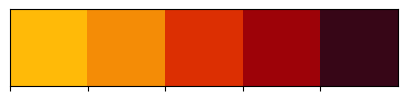

In [26]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

monocrome_hot = ["#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
monochrome_hot_palette = sns.color_palette(palette=monocrome_hot[::-2]) #sns.husl_palette()

sns.palplot(monochrome_hot_palette)


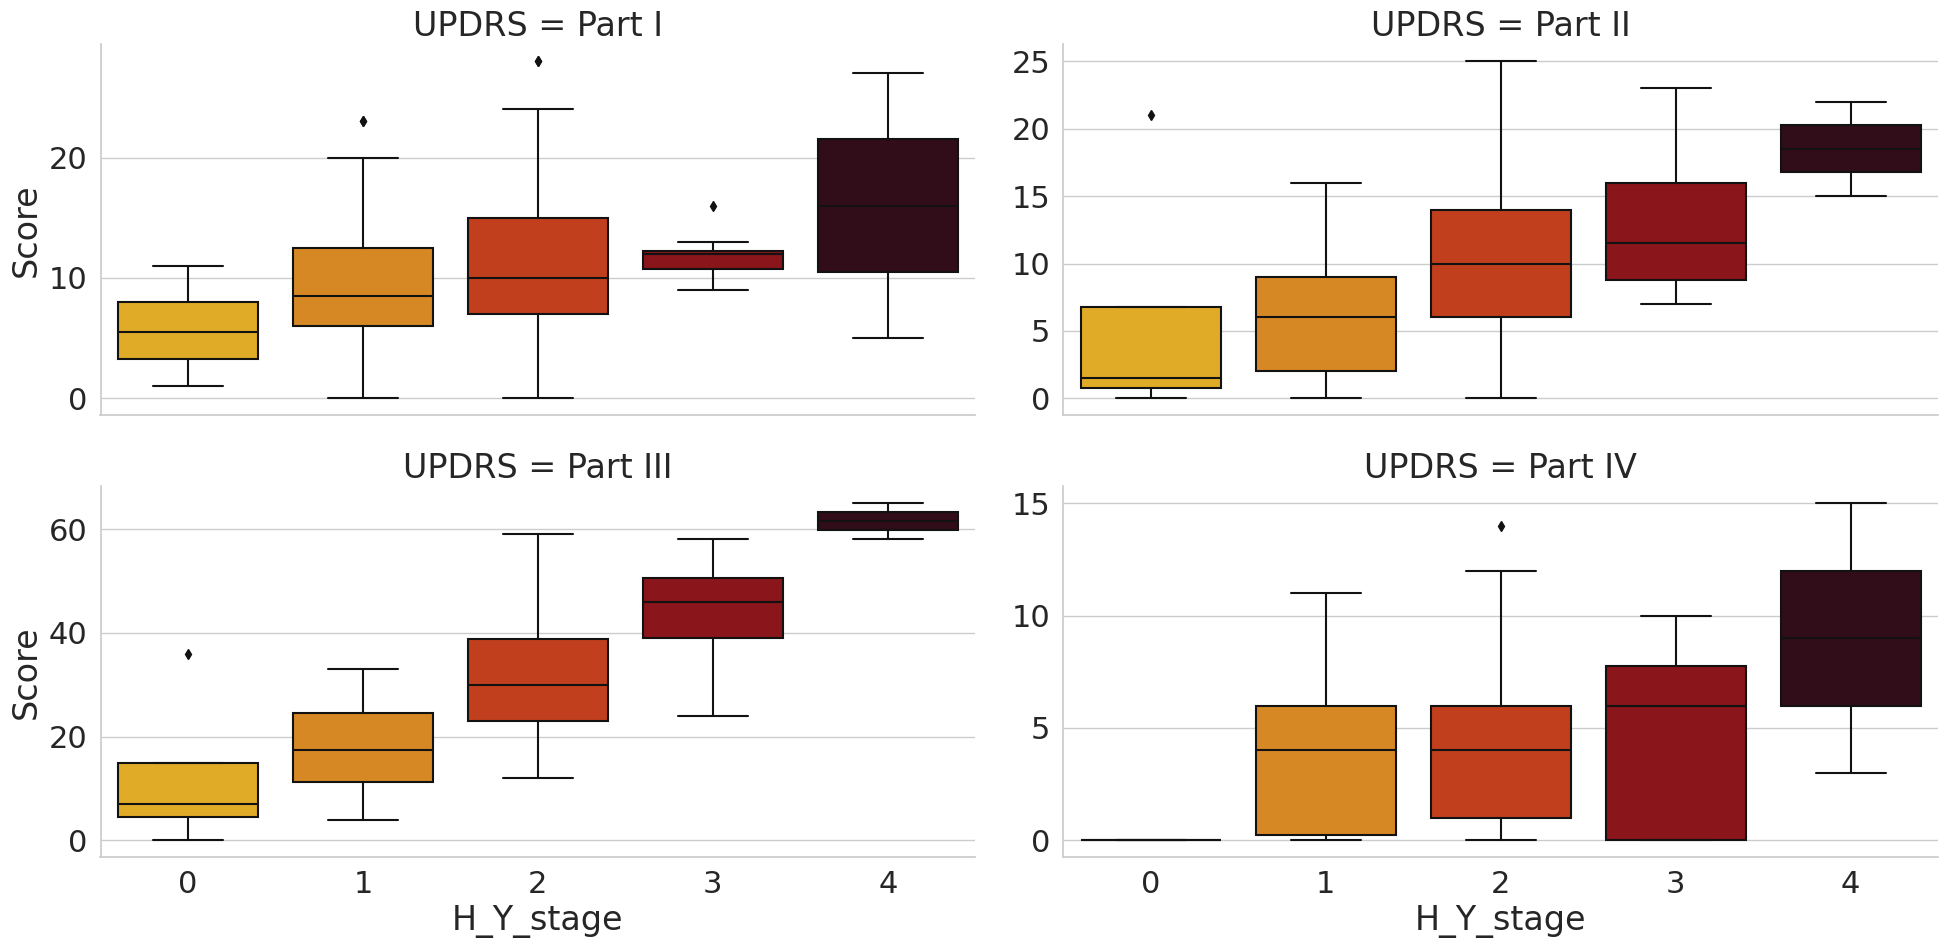

In [27]:
plot_df = pheno_df.copy()

# drop moca
plot_df = plot_df.drop(columns=["moca_scores"])

updrs_cols_dict = {
    "Hoehn and Yahr Stage: ":'H_Y_stage',
    'Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL)':'Part I',
    'Part II: Motor Aspects of Experiences of Daily Living (M-EDL)':'Part II',
    'Part III: Motor Examination':'Part III',
    'Part IV: Motor Complications':'Part IV',
}

plot_df = plot_df.rename(columns=updrs_cols_dict)

H_Y_stage_dict = zip(
    [
    '(2) Bilateral involvement without impairment of balance',
    '(3) Bilateral disease: mild to moderate disability with impaired postural reflexes; physically independent; needs assistance to recover from pull test',
    '(1) Unilateral involvement only, usually with minimal or no functional disability',
    '(0) Asymptomatic',
    '(4) Severely disabling disease; still able to walk or stand unassisted',
    np.nan], 
    
    ['2', '3', '1', '0', '4', "N/A"])

H_Y_stage_dict = dict(H_Y_stage_dict)

plot_df["H_Y_stage"] = plot_df["H_Y_stage"].replace(H_Y_stage_dict)
plot_df = plot_df[plot_df["H_Y_stage"]!="N/A"]

plot_df = pd.melt(plot_df, id_vars=["participant_id","redcap_event_name","group","H_Y_stage"], 
                  value_vars=['Part I', 'Part II', 'Part III', 'Part IV'], 
                  var_name="UPDRS", value_name="Score")

plot_df = plot_df[plot_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

stage_order = ['0', '1', '2', '3', '4']

sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="Score",x="H_Y_stage", order=stage_order,
                    col="UPDRS", col_wrap=2, 
                    kind="box", palette=monochrome_hot_palette, 
                    data=plot_df, aspect=2, height=5, sharey=False)
    # g.set_xlabels("")
    # g.set_xticklabels("")

In [28]:
plot_df["group"].value_counts()

group
PD         596
Unknown      4
Name: count, dtype: int64

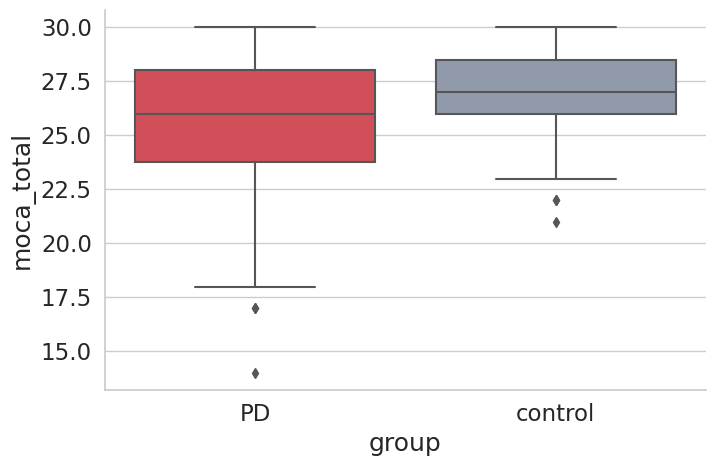

In [29]:
plot_df = pheno_df.copy()

plot_df = plot_df[plot_df["group"].isin(["PD","control"])]

plot_df = plot_df.rename(columns={"moca_scores":"moca_total"})

sns.set_theme(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="moca_total",x="group",
                    kind="box", palette=palette, 
                    data=plot_df, aspect=1.5, height=5, sharey=False)

In [30]:
for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_df = pheno_df[pheno_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 2 and averaging 5
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count    0.0  (0) Asymptomatic  \
0                   Baseline (Arm 1: C-OPN)    204  177.0               4.0   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     19    NaN               NaN   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)      6    NaN               NaN   

   (1) Unilateral involvement only, usually with minimal or no functional disability  \
0                                               34.0                                   
1                                                NaN                                   
2                                                NaN                                   

   (2) Bilateral involvement without impairment of balance  \
0                                              101.0         
1                                               10.0         
2                                                2

### Neuropsy scores

In [31]:
neuropsych_df[neuropsych_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"].isna().sum().sort_values(ascending=True)[:20]

participant_id                                                 0
redcap_event_name                                              0
Trial 2 raw                                                   29
Was the Stroop Colour and Word (D-KEFS) test administered?    29
Trial total 1,2,3 (Raw score)                                 29
Digit span backward - longest correct serie (Raw score)       29
Digit Span Backward - total correct (Raw score)               29
Trial 1 raw                                                   29
Was the Stroop Colour and Word test (Golden) administered?    29
Brixton raw score                                             29
Was the Hopkins Verbal Learning Test Revised administered?    29
Repetitions total 1,2,3 (Raw score)                           29
BNT sans indice (Raw score)                                   29
Was the WAIS IV Digit Span test administered?                 29
BNT sans indice + IS                                          29
Intrusions total 1,2,3 (R

In [32]:
index_cols = ["participant_id", "redcap_event_name","group"]
cat_cols = []

# redcap data
if neuropsy_source == "redcap":
    score_cols = [
                    "Trial total 1,2,3 (Raw score)",
                    "Intrusions total 1,2,3 (Raw score)",
                    "Repetitions total 1,2,3 (Raw score)",
                    "Digit Span Forward - total correct (Raw score) ",
                    "Digit span forward - longest correct serie (Raw score)",
                    "Digit Span Backward - total correct (Raw score)",
                    "Digit span backward - longest correct serie (Raw score)  ",    
                    "Command Clock raw (max 10)",
                    "Copy Clock raw (max 10)",
                    "STROOP GOLDEN : WORDS, number of responses",
                    "STROOP GOLDEN : words, self-corrected errors (raw score)",
                    "STROOP GOLDEN, words, uncorrected errors (raw score)",
                    "STROOP GOLDEN : COLORS Number of responses",
                    "STROOP GOLDEN : colors, self-corrected errors (raw scores)",
                    "STROOP GOLDEN: colors, uncorrected errors",
                    "Stroop GOLDEN: INK Number of Responses ",
                    "Stroop GOLDEN : ink, self-corrected errors (raw score)",
                    "Stroop GOLDEN, ink, uncorrected errors (raw score)",
                    "Letter Fluency Total (Raw score)",
                    "Semantic Fluency Total (Automatic Calculation)"
                ]   

# BD_RPQ data
if neuropsy_source == "local":
    score_cols = [
                    "HVLT Trial total 1,2,3 (Raw score)",
                    "Clock Command (Raw score)",
                    "Clock Copy (Raw score)",
                    "Semantic Fluency Total (Raw score)",
                    "RCFT Copy (Raw score)",
                    "Letter Fluency Total (Raw score)",
                    "STROOP GOLDEN : words, self-corrected errors (raw score)",
                    "STROOP GOLDEN : colors, self-corrected errors (raw scores)",
                    "Stroop GOLDEN : ink, self-corrected errors (raw score)",                
                    ]

neuropsy_vars = index_cols + cat_cols + score_cols
neuropsy_df = paper_df[neuropsy_vars]
n_participants = neuropsy_df["participant_id"].nunique()
print(f"Number of participants: {n_participants}")

neuropsy_df.head()

Number of participants: 287


,participant_id,redcap_event_name,group,"Trial total 1,2,3 (Raw score)","Intrusions total 1,2,3 (Raw score)","Repetitions total 1,2,3 (Raw score)",Digit Span Forward - total correct (Raw score),Digit span forward - longest correct serie (Raw score),Digit Span Backward - total correct (Raw score),Digit span backward - longest correct serie (Raw score),...,"STROOP GOLDEN : words, self-corrected errors (raw score)","STROOP GOLDEN, words, uncorrected errors (raw score)",STROOP GOLDEN : COLORS Number of responses,"STROOP GOLDEN : colors, self-corrected errors (raw scores)","STROOP GOLDEN: colors, uncorrected errors",Stroop GOLDEN: INK Number of Responses,"Stroop GOLDEN : ink, self-corrected errors (raw score)","Stroop GOLDEN, ink, uncorrected errors (raw score)",Letter Fluency Total (Raw score),Semantic Fluency Total (Automatic Calculation)
0,MNI0028,Baseline (Arm 1: C-OPN),PD,25.0,1.0,7.0,8.0,6.0,7.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,33.0
1,MNI0056,Baseline (Arm 1: C-OPN),PD,11.0,1.0,2.0,8.0,5.0,6.0,3.0,...,997.0,997.0,997.0,997.0,997.0,997.0,997.0,997.0,NaN,20.0
2,MNI0058,Baseline (Arm 1: C-OPN),PD,26.0,0.0,1.0,11.0,7.0,7.0,5.0,...,997.0,997.0,997.0,997.0,997.0,997.0,997.0,997.0,NaN,37.0
3,MNI0068,Baseline (Arm 1: C-OPN),PD,21.0,1.0,2.0,9.0,6.0,10.0,5.0,...,997.0,997.0,997.0,997.0,997.0,997.0,997.0,997.0,NaN,27.0
4,MNI0079,Baseline (Arm 1: C-OPN),PD,31.0,0.0,2.0,6.0,5.0,7.0,4.0,...,997.0,997.0,997.0,997.0,997.0,997.0,997.0,997.0,NaN,46.0


In [33]:
neuropsy_df[score_cols].isna().sum(axis=0)

Trial total 1,2,3 (Raw score)                                  63
Intrusions total 1,2,3 (Raw score)                             63
Repetitions total 1,2,3 (Raw score)                            63
Digit Span Forward - total correct (Raw score)                 63
Digit span forward - longest correct serie (Raw score)         63
Digit Span Backward - total correct (Raw score)                63
Digit span backward - longest correct serie (Raw score)        63
Command Clock raw (max 10)                                     63
Copy Clock raw (max 10)                                        63
STROOP GOLDEN : WORDS, number of responses                    108
STROOP GOLDEN : words, self-corrected errors (raw score)      108
STROOP GOLDEN, words, uncorrected errors (raw score)          108
STROOP GOLDEN : COLORS Number of responses                    108
STROOP GOLDEN : colors, self-corrected errors (raw scores)    108
STROOP GOLDEN: colors, uncorrected errors                     108
Stroop GOL

In [34]:
for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_df = neuropsy_df[neuropsy_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 0 and averaging 20
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count  \
0                   Baseline (Arm 1: C-OPN)    204   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     19   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)      6   

  Trial total 1,2,3 (Raw score) Intrusions total 1,2,3 (Raw score)  \
0        21.6 (5.4) [7.0, 34.0]         387.6 (485.7) [0.0, 999.0]   
1          nan (nan) [nan, nan]               nan (nan) [nan, nan]   
2       27.3 (2.1) [25.0, 29.0]               2.7 (4.6) [0.0, 8.0]   

  Repetitions total 1,2,3 (Raw score)  \
0          388.1 (485.3) [0.0, 999.0]   
1                nan (nan) [nan, nan]   
2               6.7 (5.0) [2.0, 12.0]   

  Digit Span Forward - total correct (Raw score)   \
0                      342.1 (468.0) [4.0, 999.0]   
1                            nan (nan) [nan, nan]   
2                           9.0 (2.6) [6.0, 11.0]   

  Digit span forward - longes

### UPDRS legacy and redcap data

In [35]:
updrs3_2019_csv = f"{tabular_data_release_dir}/tabular/recruitment/updrs3_2019.csv"
mds_updrs_hackathon_csv = f"{tabular_data_release_dir}/tabular/recruitment/mds_updrs_hackathon.csv"

updrs3_2019_df = pd.read_csv(updrs3_2019_csv)
mds_updrs_hackathon_df = pd.read_csv(mds_updrs_hackathon_csv)

updrs3_2019_participants = updrs3_2019_df["Record ID:"].unique()
mds_updrs_hackathon_participants = mds_updrs_hackathon_df["Record ID:"].unique()

n_updrs3_2019_participants = len(updrs3_2019_participants)
n_mds_updrs_hackathon_participants = len(mds_updrs_hackathon_participants)

print(f"Number of participants in UPDRS3 2019: {n_updrs3_2019_participants}")
print(f"Number of participants in MDS UPDRS Hackathon: {n_mds_updrs_hackathon_participants}")

Number of participants in UPDRS3 2019: 50
Number of participants in MDS UPDRS Hackathon: 23


In [36]:
updrs_redcap_participants = pheno_var_df[pheno_var_df["Part III: Motor Examination"].notna()]["participant_id"].unique()
print(f"Number of participants with UPDRS data in redcap: {len(updrs_redcap_participants)}")

paper_participants = paper_df["participant_id"].unique()
print(f"Number of participants in paper: {len(paper_participants)}")

updrs_missing_participants = set(paper_participants) - set(updrs_redcap_participants) - set(updrs3_2019_participants) - set(mds_updrs_hackathon_participants)
n_updrs_missing_participants = len(updrs_missing_participants)
print(f"Number of participants missing UPDRS data: {n_updrs_missing_participants}")

Number of participants with UPDRS data in redcap: 155
Number of participants in paper: 287
Number of participants missing UPDRS data: 110


In [37]:
len(list(set(paper_participants) & set(mds_updrs_hackathon_participants)))

18

### Suivi updrs dates

In [38]:
current_recruit_manifest_xls = f"{tabular_data_release_dir}/tabular/recruitment/Suivi_RPQ.xlsx"


col_range = "A:BD"




col_rename_dict = {
    "subj_id":"participant_id",
    "IRM01\n(J-M-A)":"IRM01_date", "#IRM 1\n PD":"IRM01_PD", "#IRM 1\n CTRL":"IRM01_CTRL", 
    "# IRM 1\n RBD":"IRM01_RBD", "# IRM 1\nOTHER":"IRM01_OTHER",
    "IRM 2 \n(J-M-A)":"IRM02_date", "#IRM 2\n PD":"IRM02_PD", "#IRM 2\n CTRL":"IRM02_CTRL", 
    "# IRM 2\n RBD":"IRM02_RBD", "# IRM 2 OTHER":"IRM02_OTHER",
    "IRM 3\n(J-M-A)":"IRM03_date", "#IRM 3\n PD":"IRM03_PD", "#IRM 3\n CTRL":"IRM03_CTRL", 
    "# IRM 3\n RBD":"IRM03_RBD", "# IRM 3 OTHER":"IRM03_OTHER",
    "MDS-UPDRS_partie_III_1\n(J-M-A)":"MDS-UPDRS_III_v01_date", 
    "MDS-UPDRS_complet (J-M-A)": "MDS-UPDRS_complete_date"
    }

useful_cols = col_rename_dict.values()

suivi_df = pd.read_excel(current_recruit_manifest_xls,sheet_name="En cours", engine='openpyxl', usecols=col_range)
suivi_df = suivi_df.rename(columns=col_rename_dict)[useful_cols].copy()

# remove the row with tally
suivi_df = suivi_df.drop([0])

# remove rows without participant_id
suivi_df = suivi_df.dropna(axis=0, subset=["participant_id"])
suivi_df = suivi_df[~suivi_df["participant_id"].astype(str).isin(["0"])] 
suivi_df["participant_id"] = suivi_df["participant_id"].str.strip().astype(str)

# remove subjects without imaging data
suivi_df = suivi_df[(suivi_df["IRM01_PD"] == 1) | (suivi_df["IRM01_CTRL"] == 1) | 
                    (suivi_df["IRM01_RBD"] == 1) | (suivi_df["IRM01_OTHER"] == 1) |
                    (suivi_df["IRM02_PD"] == 1) | (suivi_df["IRM02_CTRL"] == 1) | 
                    (suivi_df["IRM02_RBD"] == 1) |(suivi_df["IRM02_OTHER"] == 1) |
                    (suivi_df["IRM03_PD"] == 1) | (suivi_df["IRM03_CTRL"] == 1) | 
                    (suivi_df["IRM03_RBD"] == 1) |(suivi_df["IRM03_OTHER"] == 1) ]


# fix participant_id formatting issues
# Some rows have Dx in participant_id and one participant with two IDs with "="
possible_delimiters = [" ", "(", "=", "\n"]
for delim in possible_delimiters:        
    suivi_df["participant_id"] = suivi_df["participant_id"].str.strip().str.split(pat=delim, n=1, expand=True)[0]

# nipoppy_participants_current
nipoppy_participants_current = suivi_df["participant_id"].dropna().unique()

suivi_df["MDS-UPDRS_III_v01_date"] = pd.to_datetime(suivi_df["MDS-UPDRS_III_v01_date"], errors="coerce")
suivi_df["MDS-UPDRS_complete_date"] = pd.to_datetime(suivi_df["MDS-UPDRS_complete_date"], errors="coerce")

suivi_df

,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM01_OTHER,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD,IRM02_OTHER,IRM03_date,IRM03_PD,IRM03_CTRL,IRM03_RBD,IRM03_OTHER,MDS-UPDRS_III_v01_date,MDS-UPDRS_complete_date
15,PD00016,26-07-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
19,PD00020,2018-05-12 00:00:00,1.0,0.0,0.0,NaN,24-11-2022,1,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,2019-05-02,2021-07-23
31,PD00032,24-07-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
47,PD00048,21-08-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2019-08-21,NaT
117,PD00119,13-08-2018,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2018-08-15,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,MNI0565,2023-09-11 00:00:00,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
2231,MNI0602,2023-11-22 00:00:00,1.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2023-11-22,2023-11-22
2234,MNI0605,15-12-2023,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
2236,MNI0607,00:00:00,1.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2023-11-30,2023-11-30


In [39]:
suivi_updrs_participants = suivi_df[(suivi_df["MDS-UPDRS_III_v01_date"].notna() | (suivi_df["MDS-UPDRS_complete_date"].notna()))]["participant_id"]
n_suivi_updrs_participants = len(suivi_updrs_participants)
print(f"Number of participants with UPDRS data in suivi: {n_suivi_updrs_participants}")

Number of participants with UPDRS data in suivi: 214


In [40]:
len(list(set(suivi_updrs_participants) & set(paper_participants)))

203

In [41]:
len(list(set(suivi_updrs_participants) & set(updrs_missing_participants)))

28

In [42]:
missing_updrs_participants_df = pd.DataFrame(list(updrs_missing_participants), columns=["participant_id"])
missing_updrs_participants_df["Suivi_date_present"] = "no"
missing_updrs_participants_df.loc[missing_updrs_participants_df["participant_id"].isin(suivi_updrs_participants),"Suivi_date_present"] = "yes"
missing_updrs_participants_df = pd.merge(missing_updrs_participants_df, demo_df, on="participant_id", how="left")
missing_updrs_participants_df


,participant_id,Suivi_date_present,redcap_event_name,MRI_age,sex,group
0,MNI0370,no,Baseline (Arm 1: C-OPN),67.92,Male,control
1,PD00910,no,Baseline (Arm 1: C-OPN),59.55,Male,control
2,MNI0489,no,Baseline (Arm 1: C-OPN),25.98,NaN,control
3,PD01318,no,Baseline (Arm 1: C-OPN),38.30,Female,control
4,PD00952,no,Baseline (Arm 1: C-OPN),53.76,Male,control
...,...,...,...,...,...,...
118,PD01100,no,Baseline (Arm 1: C-OPN),69.83,Female,control
119,MNI0482,no,Baseline (Arm 1: C-OPN),NaN,NaN,Unknown
120,MNI0326,no,Baseline (Arm 1: C-OPN),46.98,Female,control
121,PD01566,no,Baseline (Arm 1: C-OPN),68.15,Female,control


In [43]:
missing_updrs_participants_df_PD = missing_updrs_participants_df[
                                                                # (missing_updrs_participants_df["Suivi_date_present"]=="yes") & 
                                                                (missing_updrs_participants_df["group"]=="PD") &
                                                                (missing_updrs_participants_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)")
                                                                ]
len(missing_updrs_participants_df_PD)


32

In [44]:
missing_updrs_participants_df_PD.reset_index().drop(columns=["index"])

,participant_id,Suivi_date_present,redcap_event_name,MRI_age,sex,group
0,PD01563,yes,Baseline (Arm 1: C-OPN),55.56,Male,PD
1,PD01090,yes,Baseline (Arm 1: C-OPN),68.41,Male,PD
2,PD00048,yes,Baseline (Arm 1: C-OPN),75.36,Male,PD
3,PD00668,yes,Baseline (Arm 1: C-OPN),78.21,Male,PD
4,PD01145,yes,Baseline (Arm 1: C-OPN),78.85,Male,PD
5,PD00757,yes,Baseline (Arm 1: C-OPN),78.72,Male,PD
6,MNI0476,no,Baseline (Arm 1: C-OPN),74.24,Female,PD
7,PD00622,yes,Baseline (Arm 1: C-OPN),66.09,Female,PD
8,PD01369,yes,Baseline (Arm 1: C-OPN),55.76,Male,PD
9,PD00653,yes,Baseline (Arm 1: C-OPN),77.12,Female,PD


In [45]:
missing_updrs_participants_df_PD.to_csv(f"{tabular_data_release_dir}/tabular/recruitment/missing_updrs_participants_after_hackathon.csv", index=False)